# 4 Preprocessing and Training<a id='4_Preprocessing_and_Training'></a>

## 4.1 Contents<a id='4.1_Contents'></a>
* [4 Preprocessing and Training](#4_Preprocessing_and_Training)
  * [4.1 Contents](#4.1_Contents)
  * [4.2 Introduction](#4.2_Introduction)
  * [4.3 Imports](#4.3_Imports)
  * [4.4 Load Data](#4.4_Load_Data)
  * [4.5 Data Cleaning](#4.5_Data_Cleaning)
  * [4.6 Split Dataset](#4.6_Split_Dataset)
  * [4.7 Preprocessing](#4.7_Preprocessing)
      * [4.7.1 Cadegorical Variable Cleaning](#4.7.1_Cadegorical_Variable_Cleaning)
      * [4.7.2 Label Encoding](#4.7.2_Label_Encoding)
      * [4.7.3 Train Test Split](#4.7.3_Train_Test_Split)
      * [4.7.4 Balancing the Data](#4.7.4_Balancing_the_Data)
      * [4.7.5 Feature Selection with RFE](#4.7.5_Feature_Selection_with_RFE)
  * [4.8 Training Models](#4.8_Training_Models)
      * [4.8.1 Dummy Classifier](#4.8.1_Dummy_Classifier)
      * [4.8.2 Random Forest](#4.8.2_Random_Forest)
      * [4.8.3 XGBoost](#4.8.3_XGBoost)
  * [4.9 Save the Model](#4.9_Save_the_Model)

## 4.2 Introduction<a id='4.2_Introduction'></a>

In this notebook I am going to first do some final data cleaning. Then, I will do preprocessing of categorical features, balance the data, and select features with RFE. Next, I will split the training data into training and test splits. Finally, I will train different models to determine which model will be used to predict the holdout set.

## 4.3 Imports<a id='4.3_Imports'></a>

In [1]:
# import the necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from numpy import savetxt, where, loadtxt
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline as imbPipeline
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.metrics import precision_recall_curve, auc
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn import __version__ as sklearn_version
import datetime

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


## 4.4 Load Data<a id='4.4_Load_Data'></a>

In the previous notebook I saved the data as 'lc_step3.csv'. The hold-out dataset was saved in the data wrangling notebook as 'LC_2016_2017_cleaned.csv'. I will load this data now. 

In [2]:
#df = pd.read_csv('../data/cleaned_data/lc_step3.csv', index_col = 'id', parse_dates=['earliest_cr_line', 'last_credit_pull_d'])
df = pd.read_csv('lc_step3.csv', index_col = 'id')

In [3]:
#df_hold = pd.read_csv('../data/cleaned_data/LC_2016_2017_cleaned.csv', index_col='id', , parse_dates=['earliest_cr_line', 'last_credit_pull_d'])
df_hold = pd.read_csv('LC_2016_2017_cleaned.csv', index_col='id')

## 4.5 Data Cleaning<a id='4.5_Data_Cleaning'></a>

Before preprocessing, I need to do some final data cleaning. I dropped a number of columns during EDA and now I am going to drop those from the hold-out set.

In [6]:
drop_col = list(set(df_hold.columns).difference(set(df.columns)))
drop_col

['loan_status', 'grade', 'home_ownership', 'emp_length']

In [7]:
# Here I will drop those same columns from the hold-out set.
df_hold.drop(drop_col, axis=1, inplace=True)
df_hold.shape

(748081, 23)

In [8]:
other = ['educational', 'renewable_energy', 'wedding', 'vacation']
housing = ['house', 'moving', 'home_improvement']

for i in other:
    df_hold['purpose'] = df_hold['purpose'].str.replace(i, 'other')

for j in housing:    
    df_hold['purpose'] = df_hold['purpose'].str.replace(j, 'housing')

In [11]:
# I am going to just keep the year of the earliest_cr_line and last_credit_pull_d columns
df['earliest_cr_line_year'] = df['earliest_cr_line'].astype('object').str.slice(0, 4)
df['last_credit_pull_d_year'] = df['last_credit_pull_d'].astype('object').str.slice(0, 4)
df_hold['earliest_cr_line_year'] = df_hold['earliest_cr_line'].astype('object').str.slice(0, 4)
df_hold['last_credit_pull_d_year'] = df_hold['last_credit_pull_d'].astype('object').str.slice(0, 4)
df.drop(['earliest_cr_line', 'last_credit_pull_d'], axis=1, inplace=True)
df_hold.drop(['earliest_cr_line', 'last_credit_pull_d'], axis=1, inplace=True)

In [16]:
df['earliest_cr_line_year'] = df['earliest_cr_line_year'].astype('int')
df['last_credit_pull_d_year'] = df['last_credit_pull_d_year'].astype('int')

## 4.6 Split Dataset<a id='4.6_Split_Dataset'></a>

df currently contains both the features and the targets (the 'defaults' column) for machine learning. I will need to seperate these before moving forward. 

In [17]:
# Split the dataset into features and target
X = df.drop('defaults', axis=1)
y = df['defaults']

In [18]:
X_hold = df_hold.drop('defaults', axis=1)
y_hold = df_hold['defaults']

## 4.7 Preprocessing<a id='4.7_Preprocessing'></a>

### 4.7.1 Cadegorical Variable Cleaning<a id='4.7.1_Cadegorical_Variable_Cleaning'></a>

The categorical columns are currently dtype object. 

In [19]:
X.select_dtypes('object').head(3)

,sub_grade,verification_status,purpose,addr_state
id,,,,
1077501,B2,Verified,credit_card,AZ
1077430,C4,Source Verified,car,GA
1077175,C5,Not Verified,small_business,IL


In [20]:
# change the object columns to category
for col in ['sub_grade', 'verification_status', 'purpose', 'addr_state']:
    X[col] = X[col].astype('category')

In [21]:
for col in ['sub_grade', 'verification_status', 'purpose', 'addr_state']:
    X_hold[col] = X_hold[col].astype('category')

### 4.7.2 Label Encoding<a id='4.7.2_Label_Encoding'></a>

In [22]:
categories = ['sub_grade', 'verification_status', 'purpose', 'addr_state']

In [23]:
label_encoder = LabelEncoder()
for col in categories:
    X[col]= label_encoder.fit_transform(X[col])

In [24]:
label_encoder = LabelEncoder()
for col in categories:
    X_hold[col]= label_encoder.fit_transform(X_hold[col])

I am going to now save the full training and holdout datasets. 

In [25]:
X.to_csv('features.csv')
y.to_csv('labels.csv')

In [26]:
! zip full_dataset.csv.zip *.csv

  adding: features.csv (deflated 72%)
  adding: labels.csv (deflated 66%)


In [27]:
X_hold.to_csv('X_hold.csv')
y_hold.to_csv('y_hold.csv')

In [28]:
! zip holdout_dataset.csv.zip *hold.csv

  adding: X_hold.csv (deflated 65%)
  adding: y_hold.csv (deflated 67%)


### 4.7.3 Train Test Split<a id='4.7.3_Train_Test_Split'></a>

Here I am going to split my dataset into training and test sets. I will have two different sets. One with the one-hot encoded dummy features and one with label encoded categorical features. The test set size is going to be 30%. Since only about 5% of loans default, I will need to set the stratify parameter.

In [ ]:
#! unzip *.zip

In [ ]:
#X = pd.read_csv('features.csv', index_col='id')
#y = pd.read_csv('labels.csv')

In [ ]:
#y.drop('id', axis=1, inplace=True)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

### 4.7.4 Balancing the Data<a id='4.7.4_Balancing_the_Data'></a>

Since the dataset only contains approximately 5% defaulted loans, the data needs to be balanced. I am going to use a combination of SMOTE to oversample the minority class and RandomUnderSampler to undersample the majority class to balance the data.

In [30]:
y_test = y_test.to_numpy().ravel()
y_train = y_train.to_numpy().ravel()

In [31]:
# summarize class distribution
counter = Counter(y_train)
print(counter)

Counter({0: 146623, 1: 33025})


In [32]:
over = SMOTE(sampling_strategy=0.25)
under = RandomUnderSampler(sampling_strategy=0.3)
steps = [('o', over), ('u', under)]
pipeline = imbPipeline(steps=steps)

In [33]:
# transform the dataset
#X, y = pipeline.fit_resample(X, y)
X_train, y_train = pipeline.fit_resample(X_train, y_train)

# summarize the new class distribution
counter = Counter(y_train)
print(counter)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Counter({0: 122183, 1: 36655})


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


### 4.7.5 Feature Selection with RFE<a id='4.7.5_Feature_Selection_with_RFE'></a>

First I am going to further reduce the size of the training set just to determine the number of features to chose for RFE.

In [37]:
rfe = RFE(estimator=RandomForestClassifier())

k = [x+1 for x in range(X_train.shape[1])]
grid_params = {'n_features_to_select': k}

# define grid search
RF_search = GridSearchCV(estimator=rfe, param_grid=grid_params, cv=2, scoring='precision_macro',error_score=0)

RF_search.fit(X_train, y_train)

print(RF_search.best_params_)

{'n_features_to_select': 21}


The grid search with RFE says that the best n_features_to_select is 21.

In [38]:
X_RFE = RF_search.transform(X_train)

In [39]:
X_RFE_test = RF_search.transform(X_test)

## 4.8 Training Models<a id='4.8_Training_Models'></a>

For ML, I plan on using trees and logistic regression. The tree based models will use the label encoded split and the logistic regression model will use the dummy split. These models do not assume that the data is a normal distribution. To scale the data, I am going to use a standard scaler just on the dummy split. 

In [40]:
# adapted from https://gist.github.com/rajaraghav/43dc6ee38d8db48dfa47b3505d0b8a2b
def print_score(true, pred, train=True):
    if train:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")
        
    elif train==False:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")

### 4.8.1 Dummy Classifier<a id='4.8.1_Dummy_Classifier'></a>

In [41]:
dummy = DummyClassifier(strategy = 'most_frequent', random_state=121)

dummy.fit(X, y)
dummy.score(X, y)

0.8161705112219452

.score is calculating the accuracy of the model. This score of 0.95 shows exactly why accuracy cannot be used for this dataset. The percentage of defaults in this data is approximately 5%. So, even with this dummy model which is predicting no loan defaults, it is accurate 94.7% of the time.

For loan defaults, we care about minimizing both false positives and false negatives. Predicting false positives means that lenders will not loan money to borrowers who would have actually paid back the loan. This loses money for the banks and lenders. Predicting false negatives means that the borrow will be lent money that will not be paid back, and also loses the bank money.

The metrics that I will use to assess my model is the f1 score and the confusion matrix.

In [42]:
f1_score(y, dummy.predict(X))

0.0

Above, the f1 score is zero. This is exactly as expected and shows that this dummy model is useless for predicting loan defaults.

### 4.8.2 Random Forest<a id='4.8.2_Random_Forest'></a>

In [43]:
#The following random forest hyperparameter tuning was taken from https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

# Number of trees in random forest
n_estimators = [100, 200]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 40, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'bootstrap': bootstrap}
print(param_grid)

{'n_estimators': [100, 200], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 17, 25, 32, 40, None], 'min_samples_split': [2, 4], 'bootstrap': [True, False]}


In [44]:
# First create the base model to tune
rf = RandomForestClassifier()

# Random search of parameters, using 3 fold cross validation, 
rf_grid = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, scoring='precision_macro')

# Fit the random search model
rf_grid.fit(X_RFE, y_train)

print(rf_grid.best_params_)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


{'bootstrap': True, 'max_depth': 40, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 200}


In [45]:
yTrain_rf_pred = rf_grid.best_estimator_.predict(X_RFE)
y_rf_pred = rf_grid.best_estimator_.predict(X_RFE_test)

print_score(y_train, yTrain_rf_pred, train=True)
print_score(y_test, y_rf_pred, train=False)

Train Result:
CLASSIFICATION REPORT:
                  0        1  accuracy  macro avg  weighted avg
precision       1.0      1.0       1.0        1.0           1.0
recall          1.0      1.0       1.0        1.0           1.0
f1-score        1.0      1.0       1.0        1.0           1.0
support    122183.0  36655.0       1.0   158838.0      158838.0
_______________________________________________
Confusion Matrix: 
 [[122183      0]
 [     0  36655]]

Test Result:
CLASSIFICATION REPORT:
                      0             1  accuracy     macro avg  weighted avg
precision      0.829281      0.506489  0.816682      0.667885      0.769944
recall         0.976400      0.107539  0.816682      0.541970      0.816682
f1-score       0.896847      0.177410  0.816682      0.537129      0.764597
support    62839.000000  14153.000000  0.816682  76992.000000  76992.000000
_______________________________________________
Confusion Matrix: 
 [[61356  1483]
 [12631  1522]]



In [49]:
# https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
# predict probabilities
rf_probs = rf_grid.predict_proba(X_RFE_test)
# keep probabilities for the positive outcome only
rf_probs = rf_probs[:, 1]

# calculate precision and recall for each threshold
rf_precision, rf_recall, _ = precision_recall_curve(y_test, rf_probs)
# calculate scores
rf_f1, rf_auc = f1_score(y_test, y_rf_pred), auc(rf_recall, rf_precision)
# summarize scores
print('Random Forrest: f1=%.3f auc=%.3f' % (rf_f1, rf_auc))

Random Forrest: f1=0.177 auc=0.361


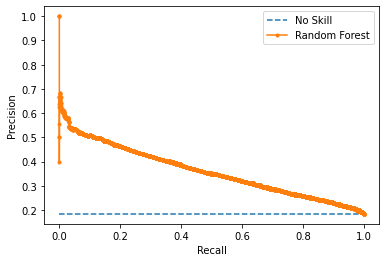

In [51]:
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(rf_recall, rf_precision, marker='.', label='Random Forest')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

In [60]:
print('The Random Forest training AUC is: ', roc_auc_score(y_train, yTrain_rf_pred))
print('The Random Forest test AUC is: ', roc_auc_score(y_test, y_rf_pred))

The Random Forest training AUC is:  1.0
The Random Forest test AUC is:  0.5419695220126669


### 4.8.3 XGBoost<a id='4.8.3_XGBoost'></a>

In [52]:
# Create the parameter grid: xgb_param_grid 
xgb_param_grid = {
    'objective': ['reg:logistic'],
    'colsample_bytree': [0.3, 0.7, 0.8],
    'n_estimators': [35, 50],
    'max_depth': [7, 10, 15],
    'eta': [0.01, 0.1, 0.2, 0.3],
}

# Instantiate the regressor: xgb
xgb_cl = xgb.XGBClassifier(eval_metric='aucpr', use_label_encoder=False)

# Perform random search: grid_xgb
grid_xgb = GridSearchCV(xgb_cl, param_grid=xgb_param_grid, cv=3, verbose=1, scoring="precision_macro")

In [53]:
# Fit grid_xgb to the data
grid_xgb.fit(X_RFE, y_train)

# Print the best parameters found
print("Best parameters found: ", grid_xgb.best_params_)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 216 out of 216 | elapsed: 44.0min finished


Best parameters found:  {'colsample_bytree': 0.3, 'eta': 0.01, 'max_depth': 7, 'n_estimators': 35, 'objective': 'reg:logistic'}


In [54]:
yTrain_xgb_pred = grid_xgb.predict(X_RFE)
y_xgb_pred = grid_xgb.predict(X_RFE_test)

print_score(y_train, yTrain_xgb_pred, train=True)
print_score(y_test, y_xgb_pred, train=False)

Train Result:
CLASSIFICATION REPORT:
                       0             1  accuracy      macro avg   weighted avg
precision       0.790366      0.911371   0.79401       0.850868       0.818290
recall          0.996530      0.118947   0.79401       0.557738       0.794010
f1-score        0.881555      0.210430   0.79401       0.545992       0.726679
support    122183.000000  36655.000000   0.79401  158838.000000  158838.000000
_______________________________________________
Confusion Matrix: 
 [[121759    424]
 [ 32295   4360]]

Test Result:
CLASSIFICATION REPORT:
                      0             1  accuracy     macro avg  weighted avg
precision      0.819750      0.562500  0.817345      0.691125      0.772462
recall         0.994987      0.028616  0.817345      0.511802      0.817345
f1-score       0.898908      0.054461  0.817345      0.476685      0.743678
support    62839.000000  14153.000000  0.817345  76992.000000  76992.000000
_______________________________________________


In [55]:
# https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
# predict probabilities
xgb_probs = grid_xgb.predict_proba(X_RFE_test)
# keep probabilities for the positive outcome only
xgb_probs = xgb_probs[:, 1]

# calculate precision and recall for each threshold
xgb_precision, xgb_recall, _ = precision_recall_curve(y_test, xgb_probs)
# calculate scores
xgb_f1, xgb_auc = f1_score(y_test, y_xgb_pred), auc(xgb_recall, xgb_precision)
# summarize scores
print('XGBoost: f1=%.3f auc=%.3f' % (xgb_f1, xgb_auc))

XGBoost: f1=0.054 auc=0.351


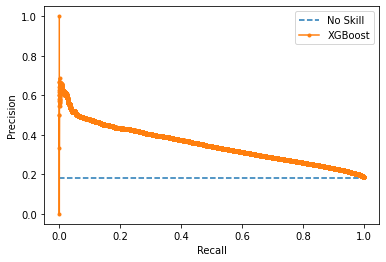

In [56]:
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(xgb_recall, xgb_precision, marker='.', label='XGBoost')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

In [58]:
print('The XGBoost training AUC is: ', roc_auc_score(y_train, yTrain_xgb_pred))
print('The XGBoost test AUC is: ', roc_auc_score(y_test, y_xgb_pred))

The XGBoost training AUC is:  0.5577383665663558
The XGBoost test AUC is:  0.5118015153243275


It looks like the random forest model predicts better than the XGBoost model. I will now save the model params and library versions to use to predict the holdout set in the next notebook.

## 4.9 Save the Model<a id='4.9_Save_the_Model'></a>

In [66]:
best_model = rf_grid.best_estimator_
best_model.version = 1.0
best_model.pandas_version = pd.__version__
best_model.numpy_version = np.__version__
best_model.sklearn_version = sklearn_version
best_model.RFE = RF_search.best_params_
best_model.build_datetime = datetime.datetime.now()

In [ ]:
# save the model
from library.sb_utils import save_file
save_file(best_model, 'LC_defaults_model.pkl')